In [1]:
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import *
import warnings

warnings.filterwarnings("ignore")


rd = pd.read_csv('rides.csv', sep=',', skipinitialspace=True)
wt = pd.read_csv('weather.csv', sep=',', skipinitialspace=True)
rd.columns = [i.lower().replace(' ', '_') for i in rd.columns]
wt.columns = [i.lower().replace(' ', '_') for i in wt.columns]
rd.end_date = rd.end_date.astype(str).apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S') if len(x) == 19 else pd.NA)
rd.start_date = rd.start_date.astype(str).apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S') if len(x) == 19 else pd.NA)
wt.datetime = wt.datetime.astype(str).apply(lambda x: dt.datetime.strptime(x.replace(' ', 'T'), '%Y-%m-%dT%H:%M:%S') if len(x) == 19 else pd.NA)
rd.drop_duplicates(subset=['id'], keep='first', inplace=True)

In [2]:
for i in rd.columns[4:8]:
    rd.loc[:, i] = rd[i].astype(str).apply(lambda x: x.lower().replace(' ', '_'))
rd

,unnamed:_0,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo
0,0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,шевченко,юго-восточный,майская,октябрьский,4069.0,0
1,1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,чехова,заречный,спортивная,октябрьский,4515.0,0
2,2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,буденного,октябрьский,суворова,ленинский,4520.0,0
3,3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,труда,центральный,рабочая,северо-западный,3881.0,0
4,4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,первомайская,северо-западный,юбилейная,юго-восточный,4029.0,0
...,...,...,...,...,...,...,...,...,...,...
102250,102250,197707,2023-07-31 23:45:06,2023-08-01 00:06:55,озерная,юго-восточный,первомайская,северо-западный,3302.0,0
102251,102251,197708,2023-07-31 23:46:01,2023-08-01 00:25:35,мичурина,ленинский,садовая,заречный,4992.0,0
102252,102252,197709,2023-07-31 23:48:04,2023-08-01 00:09:21,лермонтова,ленинский,куйбышева,центральный,2781.0,0
102253,102253,197710,2023-07-31 23:51:41,2023-08-01 00:38:04,рябиновая,северо-западный,энергетиков,юго-восточный,6466.0,0


In [3]:
wt

,unnamed:_0,datetime,temperature,precipitation_total,wind_gust,wind_speed,cloud_cover_total,sunshine_duration
0,0,<NA>,°C,mm,km/h,km/h,%,min
1,1,2023-04-01 00:00:00,8.740245,0.1,48.6,21.638964,90,0
2,2,2023-04-01 01:00:00,9.040245,0.2,55.44,22.493519,74,0
3,3,2023-04-01 02:00:00,8.880245,0.3,55.8,22.26477,72,0
4,4,2023-04-01 03:00:00,8.690246,0.3,55.44,21.94524,77,0
...,...,...,...,...,...,...,...,...
3668,3668,2023-08-31 19:00:00,16.940245,0,10.799999,1.08,89,1.4999998
3669,3669,2023-08-31 20:00:00,16.630245,0,11.159999,1.1384199,83,0
3670,3670,2023-08-31 21:00:00,17.080246,0.1,17.64,3.396233,82,0
3671,3671,2023-08-31 22:00:00,17.180244,0,21.599998,7.2359104,80,0


# Предобработка данных, очистка от выбросов и заполнение пропусков
#### Для начала на табличке без пропусков найдём средние значения времени поездки, скорости, расстояния и т.п. для дальнейшего заполнения пропусков

In [4]:
rd1 = rd.dropna()
rd1['start_date'] = pd.to_datetime(rd1['start_date'])
rd1['end_date'] = pd.to_datetime(rd1['end_date'])

rd1.loc[:, 'duration_sec'] = (rd1.loc[:, 'end_date'] - rd1.loc[:, 'start_date']).dt.total_seconds().astype(int)

0.9336041157875818


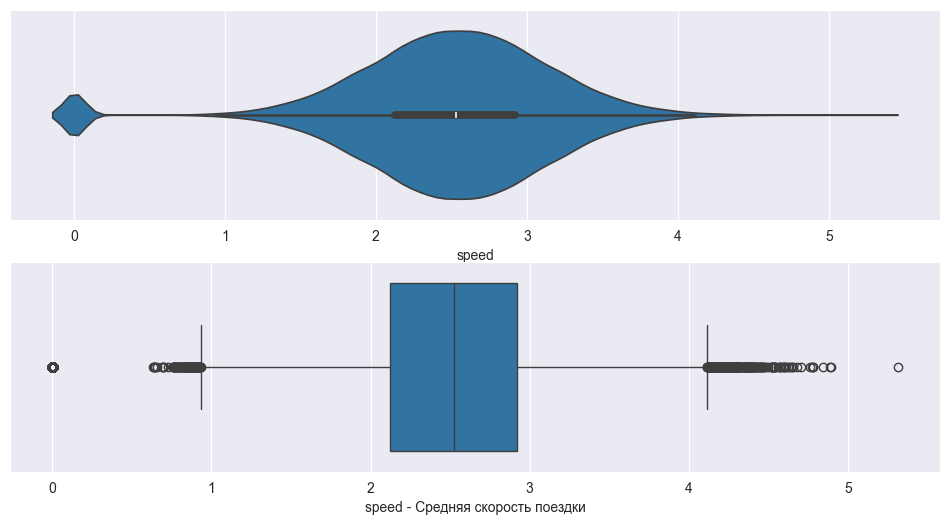

In [30]:
rd1.loc[:, 'speed'] = (rd1.loc[:, 'distance'] / rd1.loc[:, 'duration_sec']).astype(float)
rd1.loc[:, 'speed'] = rd1['speed'].where(rd1['speed'] <= 1000, pd.NA).dropna()  # находим скорость и ограничиваем экстремальные выбросы

fig, axes = plt.subplots(2, 1, figsize=(12, 6))
sns.violinplot(rd1.speed, orient='h', ax=axes[0])
sns.boxplot(rd1.speed, orient='h', ax=axes[1])
plt.xlabel('speed - Средняя скорость поездки')
print(rd1.speed.quantile(0.25) - 1.5 * (rd1.speed.quantile(0.75) - rd1.speed.quantile(0.25)))

5.311881188118812

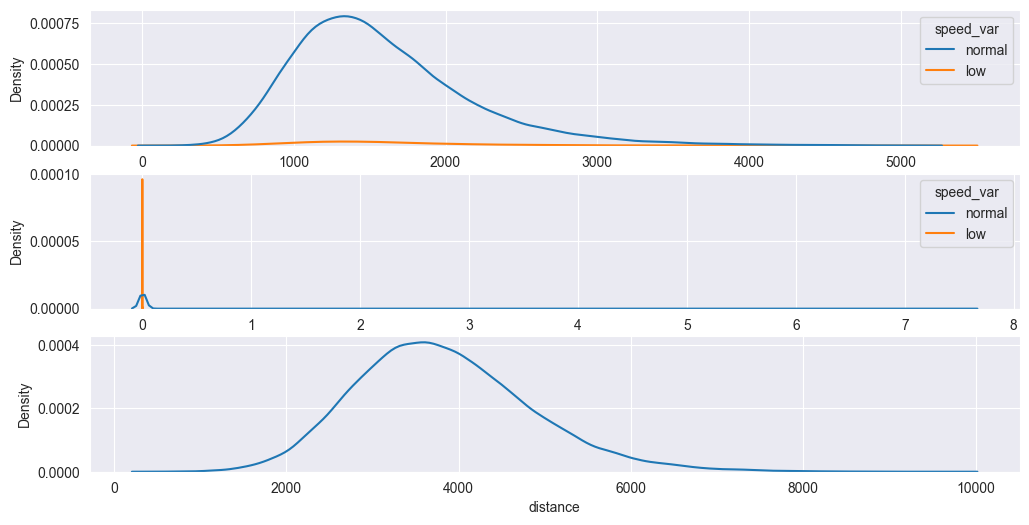

In [40]:
fig, axes = plt.subplots(3, 1, figsize=(12, 6))
rd1.loc[:, 'speed_var'] = rd1.speed.apply(lambda x: 'low' if x <= 0.9336 else 'normal')
sns.kdeplot(data=rd1, x='duration_sec', hue='speed_var', ax=axes[0])
sns.kdeplot(data=rd1, x='distance', hue='speed_var', ax=axes[1])
sns.kdeplot(data=rd1[rd1['speed'] >= 1], x='distance', ax=axes[2])
max(rd1.speed)

#### 5.31 м/с = 19.116 км/ч - вполне реальная величина скорости для самокатов, это намного ниже максимальной скорости большинства электросамокатов, а вот скорости, очень близкие к нулю - подозрительны, однако могут объясняться слишком большой продолжительностью поездки

<Axes: xlabel='duration_sec', ylabel='speed'>

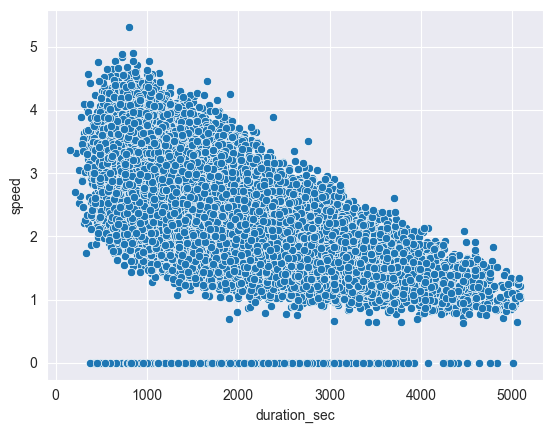

In [10]:
sns.scatterplot(data=rd1, x='duration_sec', y='speed')

<Axes: xlabel='distance', ylabel='duration_sec'>

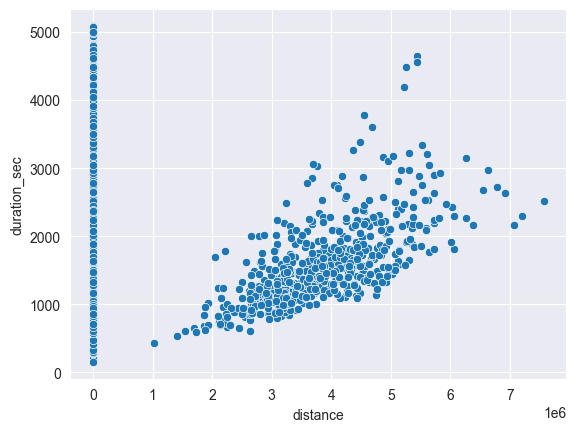

In [11]:
sns.scatterplot(data=rd1, x='distance', y='duration_sec')

In [39]:
rd1[rd1['speed_var'] == 'low']

,unnamed:_0,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,duration_sec,speed,speed_var
8,8,100348,2023-04-22 09:21:42,2023-04-22 09:39:04,западная,ленинский,озерная,юго-восточный,3.0,0,1042,0.002879,low
21,21,100360,2023-04-22 10:01:51,2023-04-22 10:31:17,лермонтова,ленинский,дружбы,центральный,5.0,0,1766,0.002831,low
67,67,100405,2023-04-22 11:08:22,2023-04-22 12:00:35,ленина,ленинский,овражная,центральный,5.0,0,3133,0.001596,low
70,70,100408,2023-04-22 11:18:25,2023-04-22 11:36:19,ул._строительная,северо-западный,ул.строительная,северо-западный,4.0,0,1074,0.003724,low
108,108,100443,2023-04-22 12:16:46,2023-04-22 12:50:14,заводская,северо-западный,свердлова,центральный,4.0,0,2008,0.001992,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102007,102007,197473,2023-07-31 19:44:01,2023-07-31 20:29:57,гоголя,центральный,энтузиастов,центральный,3.0,0,2756,0.001089,low
102072,102072,197538,2023-07-31 20:23:15,2023-07-31 20:53:32,полевая,ленинский,ул.чапаева,северо-западный,3.0,0,1817,0.001651,low
102117,102117,197581,2023-07-31 20:57:53,2023-07-31 21:33:29,октябрьская,заречный,солнечная,центральный,6.0,0,2136,0.002809,low
102149,102149,197611,2023-07-31 21:22:02,2023-07-31 21:40:39,трудовая,центральный,гоголя,центральный,4.0,0,1117,0.003581,low


In [48]:
rd1.loc[:, 'go'] = rd1.loc[:, 'end_location'] + rd1.loc[:, 'end_district'] + rd1.loc[:, 'end_location'] + rd1.loc[:, 'end_district']
mask = rd1['speed'] < 0.9336
rd1.loc[mask, 'speed'] = rd1.loc[mask].groupby('go')['speed'].transform('mean')
rd1.loc[:, 'speed_var'] = rd1.speed.apply(lambda x: 'low' if x <= 0.9336 else 'normal')
rd1[rd1['speed_var'] == 'low']

,unnamed:_0,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,duration_sec,speed,speed_var,go
8,8,100348,2023-04-22 09:21:42,2023-04-22 09:39:04,западная,ленинский,озерная,юго-восточный,3.0,0,1042,0.002609,low,озернаяюго-восточныйозернаяюго-восточный
21,21,100360,2023-04-22 10:01:51,2023-04-22 10:31:17,лермонтова,ленинский,дружбы,центральный,5.0,0,1766,0.064888,low,дружбыцентральныйдружбыцентральный
67,67,100405,2023-04-22 11:08:22,2023-04-22 12:00:35,ленина,ленинский,овражная,центральный,5.0,0,3133,0.046175,low,овражнаяцентральныйовражнаяцентральный
70,70,100408,2023-04-22 11:18:25,2023-04-22 11:36:19,ул._строительная,северо-западный,ул.строительная,северо-западный,4.0,0,1074,0.157743,low,ул.строительнаясеверо-западныйул.строительнаяс...
108,108,100443,2023-04-22 12:16:46,2023-04-22 12:50:14,заводская,северо-западный,свердлова,центральный,4.0,0,2008,0.047036,low,свердловацентральныйсвердловацентральный
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102007,102007,197473,2023-07-31 19:44:01,2023-07-31 20:29:57,гоголя,центральный,энтузиастов,центральный,3.0,0,2756,0.036366,low,энтузиастовцентральныйэнтузиастовцентральный
102072,102072,197538,2023-07-31 20:23:15,2023-07-31 20:53:32,полевая,ленинский,ул.чапаева,северо-западный,3.0,0,1817,0.002385,low,ул.чапаевасеверо-западныйул.чапаевасеверо-запа...
102117,102117,197581,2023-07-31 20:57:53,2023-07-31 21:33:29,октябрьская,заречный,солнечная,центральный,6.0,0,2136,0.072750,low,солнечнаяцентральныйсолнечнаяцентральный
102149,102149,197611,2023-07-31 21:22:02,2023-07-31 21:40:39,трудовая,центральный,гоголя,центральный,4.0,0,1117,0.042130,low,гоголяцентральныйгоголяцентральный


#### Как видно, заполнение пропусков значениями средней скорости поездки между пунктами не помогло избавиться ни от одного значения, близкого к нулю. Видно, что основная причина низких скоростей - очень маленькое расстояние - исследуем расстояние, которое проходят самокаты во время поездок со скоростью, близкой к нулю (<0.9336)

<Axes: xlabel='distance', ylabel='Density'>

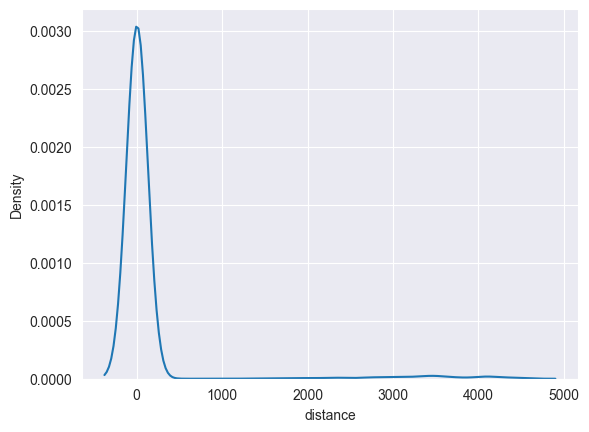

In [61]:
sns.kdeplot(data=rd1[rd1['speed_var'] == 'low'], x='distance')